## Importing Libraries

In [1]:
import os
import glob
import time
import random
import shutil
import zipfile
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray

import matplotlib.pyplot as plt
%matplotlib inline

## Loading Dataset

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/Colab Notebooks/kaggle.json' ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [3]:
!kaggle datasets download -d ktaebum/anime-sketch-colorization-pair -p /tmp/

100% 11.6G/11.6G [04:47<00:00, 58.8MB/s]
100% 11.6G/11.6G [04:47<00:00, 43.4MB/s]


In [4]:
local_training_zip = '/tmp/anime-sketch-colorization-pair.zip'
if zipfile.is_zipfile(filename=local_training_zip):
    zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r', compression=0, allowZip64=True)
    zip_ref.extractall(path='/tmp/')
    zip_ref.close()

In [5]:
# removing unwanted data
os.remove(path=local_training_zip)

tmp1 = '/tmp/data/colorgram/'
for i in os.listdir(path=tmp1):
    os.remove(path=tmp1+i)
os.rmdir(path=tmp1)

tmp2 = '/tmp/data/data/'
for i in os.listdir(path=tmp2):
    tmp2_sub = tmp2+i+'/'
    for j in os.listdir(path=tmp2_sub):
        os.remove(path=tmp2_sub+j)
    os.rmdir(path=tmp2_sub)
os.rmdir(path=tmp2)

## Analyzing Dataset

In [6]:
TRAIN_DIR = '/tmp/data/train/'
VAL_DIR = '/tmp/data/val/'

In [7]:
print('Number of Training Images:', len(os.listdir(TRAIN_DIR)))
print('Number of Validation Images:', len(os.listdir(VAL_DIR)))

Number of Training Images: 14224
Number of Validation Images: 3545


Random 5 images from training set


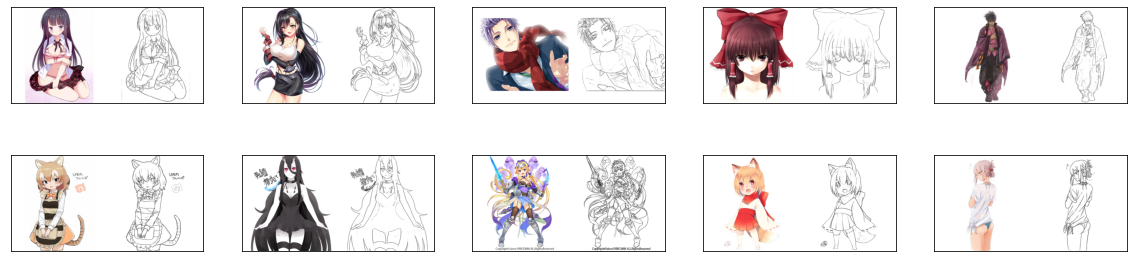

In [8]:
print('Random 5 images from training set')
plt.figure(figsize=(20, 5))

for i in range(1, 11):
    img_name = random.choice(os.listdir(TRAIN_DIR))
    img = plt.imread(TRAIN_DIR + img_name)
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

In [9]:
# randomly selecting a image & checking for dimensions
img_name = random.choice(os.listdir(TRAIN_DIR))
img = plt.imread(TRAIN_DIR + img_name)
img.shape

(512, 1024, 3)

In [10]:
# no need for normalizing
print('Minimum Value:', np.min(img))
print('Maximum Value:', np.max(img))

Minimum Value: 0.0
Maximum Value: 1.0


## Creating Model

### Approach-1

In [11]:
class ConvolutionAutoEncoder(tf.keras.Model):
    '''Convolutional AutoEncoder'''
    
    def __init__(self, original_dim):
        '''
            Input: original_dim => Input Dimension
            Output: It creates the architecture based on inputs
        '''
        super(ConvolutionAutoEncoder, self).__init__(name='CAE')

                
        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=original_dim),
            tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        ], name='Encoder')
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=self.encoder.output.shape[1:]),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=2, kernel_size=(3, 3), padding='same', activation='tanh'),
        ], name='Decoder')

        super(ConvolutionAutoEncoder, self).build((None, *original_dim))
    
    
    def call(self, input_features):
        '''
            Feeds input-data to the model architecture
        '''
        encodings = self.encoder(input_features)
        return self.decoder(encodings)

### Approach-2

In [12]:
# class ConvolutionAutoEncoder(tf.keras.Model):
#     '''Convolutional AutoEncoder'''
    
#     def __init__(self, original_dim):
#         '''
#             Input: original_dim => Input Dimension
#             Output: It creates the architecture based on inputs
#         '''
#         super(ConvolutionAutoEncoder, self).__init__(name='CAE')

                
#         # Encoder
#         self.encoder = tf.keras.Sequential([
#             tf.keras.layers.InputLayer(input_shape=original_dim),
#             tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'),
#             tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu', strides=2),
#             tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
#             tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', strides=2),
#             tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
#             tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', strides=2),
#         ], name='Encoder')
        
#         # Decoder
#         self.decoder = tf.keras.Sequential([
#             tf.keras.layers.InputLayer(input_shape=self.encoder.output.shape[1:]),
#             tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', strides=2),
#             tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
#             tf.keras.layers.UpSampling2D(size=(2, 2)),
#             tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
#             tf.keras.layers.UpSampling2D(size=(2, 2)),
#             tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'),
#             tf.keras.layers.UpSampling2D(size=(2, 2)),
#             tf.keras.layers.Conv2D(filters=2, kernel_size=(3, 3), padding='same', activation='tanh'),
#             tf.keras.layers.UpSampling2D(size=(2, 2))
#         ], name='Decoder')

#         super(ConvolutionAutoEncoder, self).build((None, *original_dim))
    
    
#     def call(self, input_features):
#         '''
#             Feeds input-data to the model architecture
#         '''
#         encodings = self.encoder(input_features)
#         return self.decoder(encodings)

## Initializing Model

In [13]:
autoencoder = ConvolutionAutoEncoder(original_dim=(512, 512, 1))
autoencoder.summary()

Model: "CAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder (Sequential)         (None, 512, 512, 64)      24384     
_________________________________________________________________
Decoder (Sequential)         (None, 512, 512, 2)       24394     
Total params: 48,778
Trainable params: 48,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_198 (Conv2D)          (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_199 (Conv2D)          (None, 256, 256, 64)      36928     
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 128, 128, 128)     147584    
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 128, 128, 256)     295168    
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 64, 64, 256)       590080    
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 64, 64, 512)       1180

In [ ]:
autoencoder.model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

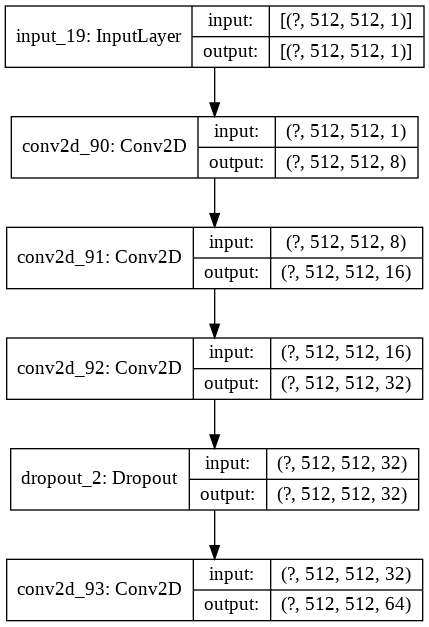

In [ ]:
tf.keras.utils.plot_model(
    model=autoencoder.encoder,
    to_file='AutoEncoder-Encoder.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)

In [ ]:
autoencoder.decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 512, 512, 32)      18464     
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 512, 512, 16)      4624      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 512, 512, 8)       1160      
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 512, 512, 2)       146       
Total params: 24,394
Trainable params: 24,394
Non-trainable params: 0
_________________________________________________________________


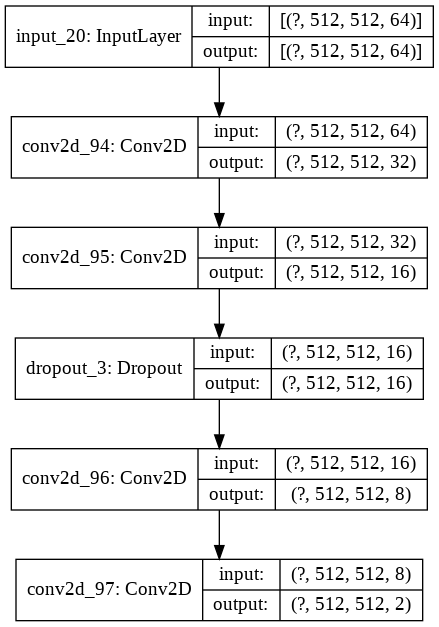

In [ ]:
tf.keras.utils.plot_model(
    model=autoencoder.decoder,
    to_file='AutoEncoder-Decoder.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)

## Compiling Model

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

## Building Generator

In [ ]:
def generator(data_dir, batch_size):
    last = len(os.listdir(data_dir))//batch_size
    for _ in range(last):
        x, y = [], []
        for i in range(batch_size):
            img_name = random.choice(os.listdir(path=data_dir))
            img = plt.imread(fname=data_dir+img_name)
            img = img[:, :512, :]
            img = rgb2lab(img)
            x.append(np.expand_dims(img[:, :, 0], axis=2))
            y.append(img[:, :, 1:])

        x, y = np.array(x), np.array(y)
        yield x, y

## Training Model

In [ ]:
history = autoencoder.fit(
    generator(data_dir=TRAIN_DIR, batch_size=4),
    epochs=10,
    steps_per_epoch=10,
    validation_data=generator(data_dir=VAL_DIR, batch_size=4),
    validation_steps=10
)

Epoch 1/10
10/10 [==============================] - 9s 862ms/step - loss: 122.0700 - val_loss: 116.2968
Epoch 2/10
10/10 [==============================] - 9s 862ms/step - loss: 113.3113 - val_loss: 118.3046
Epoch 3/10
10/10 [==============================] - 9s 867ms/step - loss: 107.5986 - val_loss: 103.9424
Epoch 4/10
10/10 [==============================] - 9s 863ms/step - loss: 111.4898 - val_loss: 134.7077
Epoch 5/10
10/10 [==============================] - 9s 855ms/step - loss: 120.4419 - val_loss: 116.3882
Epoch 6/10
10/10 [==============================] - 9s 868ms/step - loss: 110.2017 - val_loss: 117.6232
Epoch 7/10
10/10 [==============================] - 9s 858ms/step - loss: 144.2315 - val_loss: 127.8226
Epoch 8/10
10/10 [==============================] - 8s 849ms/step - loss: 153.0689 - val_loss: 141.7699
Epoch 9/10
10/10 [==============================] - 9s 858ms/step - loss: 109.6955 - val_loss: 99.7448
Epoch 10/10
10/10 [==============================] - 9s 861ms/ste

## Analyzing Model

In [ ]:
def plot_result(history, components=['loss', 'val_loss'], colors=['b','r'], labels=['Training loss', 'Validation loss'], locs=[5, -10]):
    '''
        Input: history => model training information
               component => element of data
               color => color to be used for plotting
               label => text for defining plots
        Output: plot of data component
    '''
    
    plt.figure(figsize=(20, 6))
    for component, color, label, loc in zip(components, colors, labels, locs):
        plt.plot(history.history[component], marker='o', color=color, label=label)
        plt.title('Loss')
        plt.legend()
        plt.xticks(history.epoch)
        for x, y in zip(history.epoch, history.history[component]):
            label = "{:.3f}".format(y)
            plt.annotate(label,                               # this is the text
                         (x, y),                              # this is the point to label
                         textcoords="offset points",          # how to position the text
                         xytext=(0, loc),                       # distance from text to points (x,y)
                         ha='center')                         # horizontal alignment can be left, right or center

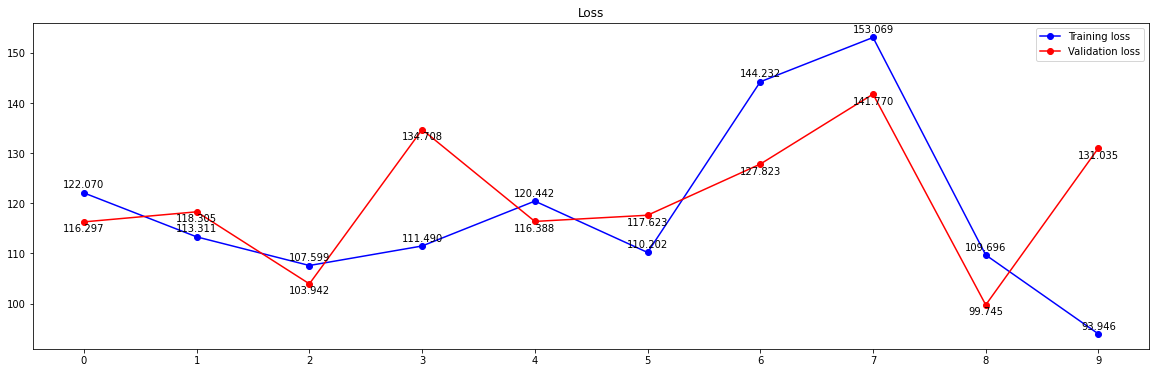

In [ ]:
plot_result(history=history)

## Testing Model

In [ ]:
# randomly selecting a image from validation set
img_name = random.choice(os.listdir(VAL_DIR))
img = plt.imread(VAL_DIR + img_name)
img = rgb2lab(img[:, :512, :])

In [ ]:
pred = autoencoder.predict(x=np.expand_dims(img[:, :, 0], axis=[0, 3]))
pred.shape

(1, 512, 512, 2)

In [ ]:
canvas = np.zeros(shape=(512, 512, 3))
canvas[:, :, 0] = img[:, :, 0]
canvas[:, :, 1:] = pred[0][:, :, :]

Text(0.5, 1.0, 'Predicted')

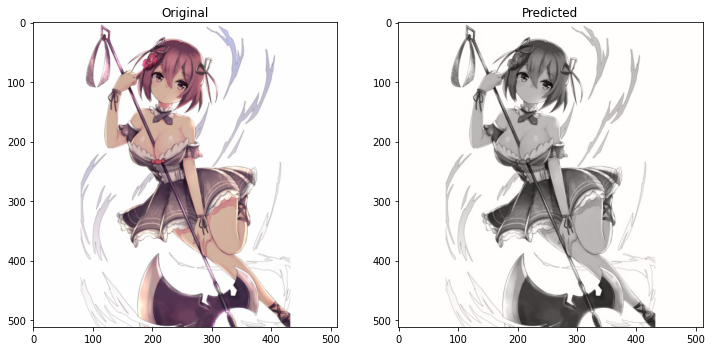

In [ ]:
plt.figure(figsize=(12, 7))

plt.subplot(1, 2, 1)
plt.imshow(lab2rgb(img))
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(lab2rgb(canvas))
plt.title('Predicted')